In [58]:
import onnxruntime as ort
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import re
import os
import argparse

onnx_model_path = "Shelf_life.onnx"
session = ort.InferenceSession(onnx_model_path)

def preprocess_images_from_directory(directory_path, target_size=(64, 64)):
    images = []
    # List all files in the directory
    img_files = [f for f in os.listdir(directory_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    # Process each image file
    for img_file in img_files:
        img_path = os.path.join(directory_path, img_file)
        # Load the image
        img = image.load_img(img_path, target_size=target_size)
        # Convert the image to a numpy array
        img_array = image.img_to_array(img)
        # Normalize the image
        img_array = img_array / 255.0
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        images.append(img_array)
    
    # Concatenate all images into a single batch
    if images:
        return np.vstack(images)
    else:
        raise ValueError("No images found in the directory.")

# Define the input name (it should match the input name in the ONNX model)
input_name = session.get_inputs()[0].name

# Specify the directory path
directory_path = 'Data/Test'

# Perform inference
preprocessed_images = preprocess_images_from_directory(directory_path)

# Perform inference
onnx_predictions = session.run(None, {input_name: preprocessed_images})

index_to_label = {
    0: 'Apple(1-5)',
    1: 'Apple(10-14)',
    2: 'Apple(5-10)',
    3: 'Banana(1-5)',
    4: 'Banana(10-15)',
    5: 'Banana(15-20)',
    6: 'Banana(5-10)',
    7: 'Carrot(1-2)',
    8: 'Carrot(3-4)',
    9: 'Expired',
    10: 'Tomato(1-5)',
    11: 'Tomato(10-15)',
    12: 'Tomato(5-10)',
    13: 'carrot(5-6)'
}

# Function to extract product name and shelf-life
def extract_product_info(label):
    match = re.match(r'(\w+)\(([\d-]+)\)', label)
    if match:
        product_name = match.group(1)
        shelf_life = match.group(2)
        return product_name, shelf_life
    return "None", 'expired'

# Collect predictions and extract information
data = []
for i, prediction in enumerate(onnx_predictions[0]):
    predicted_class_index = np.argmax(prediction)
    label = index_to_label[predicted_class_index]
    product, shelf_life = extract_product_info(label)
    data.append({'Image': f'Image {i+1}', 'product': product, 'shelf_life': shelf_life})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


       Image product shelf_life
0    Image 1  Banana      15-20
1    Image 2  Banana      15-20
2    Image 3  Banana      15-20
3    Image 4   Apple      10-14
4    Image 5   Apple      10-14
5    Image 6  Carrot        1-2
6    Image 7   Apple      10-14
7    Image 8  Carrot        1-2
8    Image 9   Apple      10-14
9   Image 10  Carrot        1-2
10  Image 11   Apple      10-14
11  Image 12  Carrot        1-2
12  Image 13  Banana        1-5
13  Image 14  Banana        1-5
14  Image 15  Banana        1-5
15  Image 16  Carrot        1-2
16  Image 17  Banana      10-15
17  Image 18  Banana        1-5
18  Image 19   Apple      10-14
19  Image 20  Carrot        1-2
20  Image 21  Banana        1-5
21  Image 22  Carrot        1-2
22  Image 23  Banana        1-5
23  Image 24    None    expired
24  Image 25    None    expired
25  Image 26    None    expired
26  Image 27  Banana      10-15
27  Image 28   Apple      10-14
28  Image 29   Apple      10-14
29  Image 30    None    expired
30  Imag

9
  product shelf_life  count
0   Apple      10-14     12
1  Banana        1-5      6
2  Banana      10-15      6
3  Banana      15-20      5
4  Carrot        1-2      7
5    None    expired      9
6  Tomato        1-5      6
7    None    expired      9


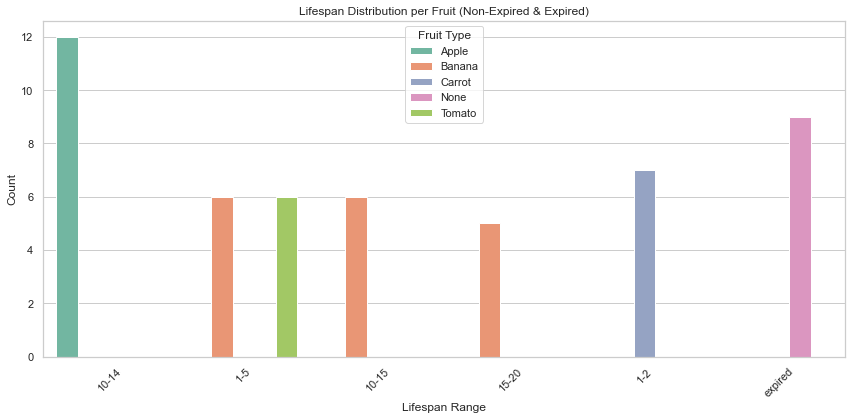

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame, replace this with your actual DataFrame
# df_filtered = pd.DataFrame({'product': ['Apple', 'Banana', 'Carrot', 'Apple'], 'shelf_life': ['1-5', '10-15', 'Expired', '5-10']})

# Assuming df_filtered is your DataFrame without expired items
lifespan_per_fruit = df.groupby(['product', 'shelf_life']).size().reset_index(name='count')

# Count the expired items
expired_count = df[df['shelf_life'] == 'expired']['product'].count()

print(expired_count)
# Create a DataFrame for expired items
expired_data = pd.DataFrame({'product': ["None"], 'shelf_life': ['expired'], 'count': [expired_count]})

# Combine the two DataFrames
lifespan_per_fruit = pd.concat([lifespan_per_fruit, expired_data], ignore_index=True)

print(lifespan_per_fruit)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(12, 6))

# Create a bar plot for lifespan per fruit
bars = sns.barplot(data=lifespan_per_fruit, x='shelf_life', y='count', hue='product', palette='Set2')

# Customize the colors of the bars
for bar in bars.patches:
    if bar.get_x() + bar.get_width() / 2 == lifespan_per_fruit[lifespan_per_fruit['product'] == "None"]['shelf_life'].values.all:
        bar.set_color('red')  # Set the color for expired items to red

# Customize the plot
plt.title('Lifespan Distribution per Fruit (Non-Expired & Expired)')
plt.xlabel('Lifespan Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Fruit Type')
plt.tight_layout()

# Show the plot
plt.show()


In [57]:
df_filtered = df[df["product"] != "None"]
print(df_filtered)
df_filtered2=df_filtered
df_filtered2['product_shelf_life'] = df_filtered2['product'] + '(' + df_filtered2['shelf_life'] + ')'

# Group by the new column and count occurrences
counts = df_filtered2['product_shelf_life'].value_counts()

# Convert to dictionary
result_dict = (counts*10).to_dict()

print(result_dict)

       Image product shelf_life  needs_refrigerated_car  needs_refrigerated
0    Image 1  Banana      15-20                   False               False
1    Image 2  Banana      15-20                   False               False
2    Image 3  Banana      15-20                   False               False
3    Image 4   Apple      10-14                   False               False
4    Image 5   Apple      10-14                   False               False
5    Image 6  Carrot        1-2                   False               False
6    Image 7   Apple      10-14                   False               False
7    Image 8  Carrot        1-2                   False               False
8    Image 9   Apple      10-14                   False               False
9   Image 10  Carrot        1-2                   False               False
10  Image 11   Apple      10-14                   False               False
11  Image 12  Carrot        1-2                   False               False
12  Image 13

In [54]:

df = pd.DataFrame(df_filtered)

refrigerated_types = ['apple', 'carrot']

df['needs_refrigerated_car'] = df['product'].apply(lambda x: True if x in refrigerated_types else False)

print(df)

       Image product shelf_life  needs_refrigerated_car
0    Image 1  Banana      15-20                   False
1    Image 2  Banana      15-20                   False
2    Image 3  Banana      15-20                   False
3    Image 4   Apple      10-14                   False
4    Image 5   Apple      10-14                   False
5    Image 6  Carrot        1-2                   False
6    Image 7   Apple      10-14                   False
7    Image 8  Carrot        1-2                   False
8    Image 9   Apple      10-14                   False
9   Image 10  Carrot        1-2                   False
10  Image 11   Apple      10-14                   False
11  Image 12  Carrot        1-2                   False
12  Image 13  Banana        1-5                   False
13  Image 14  Banana        1-5                   False
14  Image 15  Banana        1-5                   False
15  Image 16  Carrot        1-2                   False
16  Image 17  Banana      10-15                 

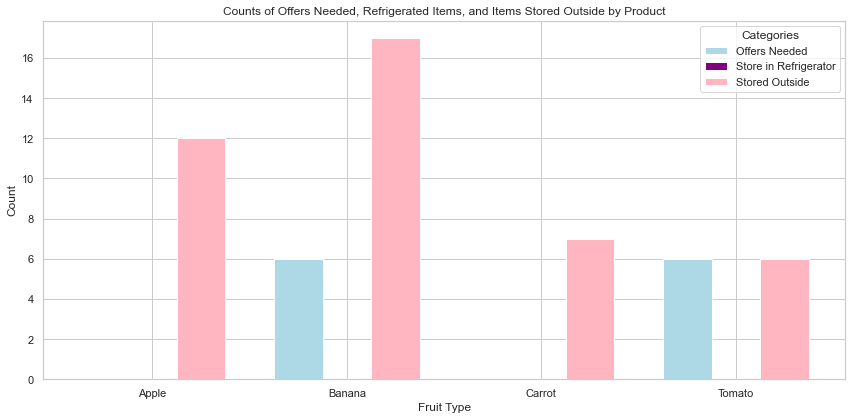

In [55]:
df_user = pd.DataFrame(df_filtered)
refrigerated_types = ['apple', 'carrot']
df_user['needs_refrigerated'] = df['product'].apply(lambda x: True if x in refrigerated_types else False)

def offer_needed(row):
    if row['product'] == 'carrot' and row['shelf_life'] in ['1-2']:
        return True
    elif row['product'] != 'carrot' and row['shelf_life'] in ['1-5']:
        return True
    else:
        return False

df_user['offer_needed'] = df_user.apply(offer_needed, axis=1)

summary_df = df_user.groupby('product').agg(
    offer_needed_count=('offer_needed', 'sum'),
    refrigerated_count=('needs_refrigerated', 'sum'),
    stored_outside_count=('needs_refrigerated', lambda x: (~x).sum())
).reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = range(len(summary_df))
plt.bar(x, summary_df['offer_needed_count'], width=bar_width, label='Offers Needed', color='lightblue', align='center')
plt.bar([p + bar_width for p in x], summary_df['refrigerated_count'], width=bar_width, label='Store in Refrigerator', color='purple', align='center')
plt.bar([p + 2 * bar_width for p in x], summary_df['stored_outside_count'], width=bar_width, label='Stored Outside', color='lightpink', align='center')
plt.title('Counts of Offers Needed, Refrigerated Items, and Items Stored Outside by Product')
plt.xlabel('Fruit Type')
plt.ylabel('Count')
plt.xticks([p + bar_width for p in x], summary_df['product'])
plt.legend(title='Categories')
plt.tight_layout()

# Show the plot
plt.show()